# Manual Damage Curves Tutorial

This tutorial demonstrates how to perform a **damage analysis using custom/manual damage curves** in RA2CE.  
Manual curves allow you to define site-specific or locally calibrated hazard–damage relationships rather than relying on generic reference curves.

This is particularly useful when:

- You have local historical damage data.
- You want to account for specific infrastructure types.
- You need to test alternative vulnerability scenarios.

----

## Step 1: Define project paths

As usual, define your project folder and subdirectories:

In [1]:
from pathlib import Path

root_dir = Path("data", "damage_manual")
static_path = root_dir.joinpath("static")
hazard_path = static_path.joinpath("hazard")
network_path = static_path.joinpath("network")
output_path = root_dir.joinpath("output")

----
## Step 2: Configure the road network and hazard

The network is downloaded from **OpenStreetMap (OSM)**, clipped to a region polygon (`polygon.geojson`).  
We specify which **road types** should be included in the analysis.

In [2]:
from ra2ce.network.network_config_data.enums.road_type_enum import RoadTypeEnum
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.network.network_config_data.enums.network_type_enum import NetworkTypeEnum
from ra2ce.network.network_config_data.network_config_data import NetworkSection
from ra2ce.ra2ce_handler import Ra2ceHandler


network_section = NetworkSection(
    network_type=NetworkTypeEnum.DRIVE,
    source=SourceEnum.OSM_DOWNLOAD,
    polygon=static_path.joinpath("polygon.geojson"),
    save_gpkg=True,
    road_types=[
        RoadTypeEnum.SECONDARY,
        RoadTypeEnum.SECONDARY_LINK,
        RoadTypeEnum.PRIMARY,
        RoadTypeEnum.PRIMARY_LINK,
        RoadTypeEnum.TRUNK,
        RoadTypeEnum.MOTORWAY,
        RoadTypeEnum.MOTORWAY_LINK,
    ],
)

c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We provide hazard input in the form of **GeoTIFF raster files** (e.g., flood depth maps).  
RA2CE will overlay these rasters with the road network to compute hazard intensities for each asset.

In [3]:
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.network_config_data import HazardSection

hazard_section = HazardSection(
    hazard_map=[Path(file) for file in hazard_path.glob("*.tif")],
    aggregate_wl=AggregateWlEnum.MEAN,  # mean water depth used in analysis
    hazard_crs="EPSG:4326",  # ensure hazard map is in EPSG:4326 projection
)

We combine the network and hazard information into a single configuration object.

In [4]:
from ra2ce.network.network_config_data.network_config_data import NetworkConfigData

network_config_data = NetworkConfigData(
    root_path=root_dir,
    static_path=static_path,
    network=network_section,
    hazard=hazard_section
)
network_config_data.network.save_gpkg = True

----
## Step 3: Define the damage analysis

Here, we specify that RA2CE should perform a **damage analysis** using **manual damage curves (MAN)** with the class [AnalysisSectionDamages](../api/ra2ce.analysis.analysis_config_data.html#ra2ce.analysis.analysis_config_data.analysis_config_data.AnalysisSectionDamages){.api-ref} and the attribute `damage_curve` set to [DamageCurveEnum.MAN](../api/ra2ce.analysis.analysis_config_data.enums.html#ra2ce.analysis.analysis_config_data.enums.damage_curve_enum.DamageCurveEnum.MAN){.api-ref}
For manual damage curves, it is important to also specify the input data in the folder path in the config `input_path`. This is the location where the custom manual curves will be defined and placed (see next step).

The event type can be set to EVENT if damages are to be calculated for the hazard maps only (example below), or to RETURN_PERIOD if the analysis should estimate risk over a specified return period (see tutorial ).

In [5]:
from ra2ce.analysis.damages.damages import AnalysisSectionDamages
from ra2ce.analysis.analysis_config_data.enums.analysis_damages_enum import AnalysisDamagesEnum
from ra2ce.analysis.analysis_config_data.enums.event_type_enum import EventTypeEnum
from ra2ce.analysis.analysis_config_data.enums.damage_curve_enum import DamageCurveEnum
from ra2ce.analysis.analysis_config_data.analysis_config_data import AnalysisConfigData

damages_analysis = [AnalysisSectionDamages(
    name='damages_reference_curve_manual',
    analysis=AnalysisDamagesEnum.DAMAGES,
    event_type=EventTypeEnum.EVENT,
    damage_curve=DamageCurveEnum.MAN,  # use manual damage curve
    save_csv=True,
    save_gpkg=True
)]

analysis_config_data = AnalysisConfigData(
    analyses=damages_analysis,
    output_path=output_path,
    input_path=root_dir.joinpath("input_data")
)

----
## Step 4: Create damage curve files

In the manual situation, two input files are expected:

1. A file that specifies the **shape of the vulnerability curve**:
   - x-axis = hazard intensity (e.g. water depth in cm)
   - y-axis = damage fraction (0–1, representing the % of total construction cost)

2. A file that specifies the **construction costs** per road type and number of lanes.

Both files should be placed in the folder `input_data/damage_functions/all_road_types/`.

### Vulnerability curve (hazard severity vs. damage fraction)

The file `hazard_severity_damage_fraction.csv` looks like:
```text
depth;damage
cm;% of total construction costs
0;0
100;0.1
200;0.2
400;0.4
800;0.8
12000;1
```

Where:
- `depth` = water depth in **cm**
- `damage` = damage fraction (0–1, relative to construction cost)

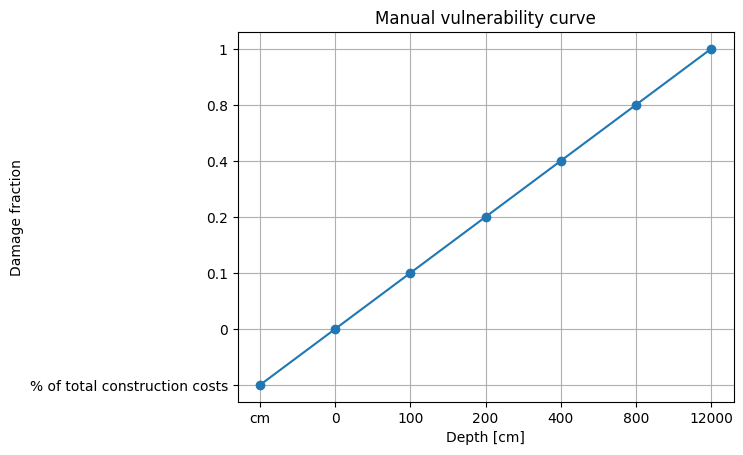

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

input_data_path = root_dir.joinpath("input_data")
vuln_curves = pd.read_csv(input_data_path.joinpath("damage_functions", "all_road_types","hazard_severity_damage_fraction.csv"), delimiter=";")

plt.plot(vuln_curves["depth"], vuln_curves["damage"], marker="o")
plt.xlabel("Depth [cm]")
plt.ylabel("Damage fraction")
plt.title("Manual vulnerability curve")
plt.grid(True)
plt.show()

![Manual vulnerability curve](/_resources/figures/manual_vuln_curve.png)

### Maximum construction costs per road type and lanes

The file `max_damage_road_types.csv` looks like:
```text
Road_type \ lanes;1;2;3;4;5;6;7;8
unit;euro/m;euro/m;euro/m;euro/m;euro/m;euro/m;euro/m;euro/m
tertiary_link;110;120;130;140;150;130;140;150
tertiary;110;120;130;140;150;130;140;150
trunk;110;120;130;140;150;130;140;150
trunk_link;110;120;130;140;150;130;140;150
secondary_link;11;12;13;14;15;13;14;15
secondary;11;12;13;14;15;13;14;15
primary_link;11;12;13;14;15;13;14;15
primary;11;12;13;14;15;13;14;15
residential;1100;1200;1300;1400;1500;1300;1400;1500
['tertiary', 'residential'];510;520;530;540;550;530;540;550
motorway;1100;1200;1300;1400;1500;1300;1400;1500
motorway_link;510;520;530;540;550;530;540;550
```

> **Note**
>
> - The *first file* defines the shape of the damage curve (hazard → damage fraction).
> - The *second file* defines the maximum construction costs per road type and lane count.
> - Together, they allow RA2CE to estimate damages in absolute currency units.

----
## Step 5: Run the analysis

In [7]:
Ra2ceHandler.run_with_config_data(network_config_data, analysis_config_data)

c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\osmnx\simplification.py:513: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged = convert.graph_to_gdfs(G, edges=False)["geometry"].buffer(tolerance).unary_union
c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\osmnx\simplification.py:560: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = node_clusters.centroid
100%|██████████| 127/127 [00:00<00:00, 126827.76it/s]
2025-10-01 05:05:17 PM - [avg_speed_calculator.py:175] - root - WARNING - No valid file found with average speeds data\damage_manual\static\output_graph\avg_speed.csv, calculating and saving them instead.
Graph hazard overlay with flood1000: 100%|██████████| 109/109 [00:00<

[DamagesResultWrapper(segment_based_result=AnalysisResult(analysis_result=                                osmid  oneway  lanes  ref     infra_type  \
 u           v          key                                                 
 42002848    4336238970 0    435722626    True    3.0   N2          trunk   
 42003549    5284280675 0    215573156    True    2.0  A79       motorway   
             5284280682 0    254696086    True    2.0   A2       motorway   
 42004326    3744093239 0    254696086    True    2.0   A2       motorway   
 42005137    2832217846 0    720205318    True    1.0  A79  motorway_link   
 ...                               ...     ...    ...  ...            ...   
 12680821393 42080697   0      6773022   False    2.0  nan      secondary   
             42080429   0      6773022   False    2.0  nan      secondary   
 12696408646 2540119540 0      6773079   False    2.0  nan      secondary   
             42083916   0      6773079   False    2.0  nan      secondary   
 13

----
## Output

The results of the manual damage analysis are provided in **two GeoPackage (GPKG) files**:

- `damages_reference_curve_manual_link_based.gpkg`: damage estimates per **network link**
- `damages_reference_curve_manual_segment.gpkg`: damage estimates per **100m segment**

Key attributes of interest (in currency):

- `dam_EV1_al` : estimated damage for the first flood map (manual method).
- `dam_EV2_al` : estimated damage for the second flood map (manual method).

You can open these files in GIS software (QGIS, ArcGIS) or load them in Python with GeoPandas:

In [ ]:
import geopandas as gpd
output_path = root_dir / "output" / 'damages'
link_based = gpd.read_file(output_path / "damages_reference_curve_manual_link_based.gpkg")
segment_based = gpd.read_file(output_path / "damages_reference_curve_manual_segmented.gpkg")

# Inspect the first rows
print(link_based.head())
print(segment_based.head())

You can open the results in GIS software to visualize which road segments are most affected by the hazard.